In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import pandas as pd
from pylab import *
import scipy
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
import itertools

dataset=pd.read_csv('train.csv', sep=',',header=0)
label=list(dataset.label)
data=dataset.iloc[:,1:]
def show_image(n):
    print("Label:",label[n])
    t= data.iloc[n].values.reshape(28,28)
    plt.matshow(t, cmap='gray')
    plt.show()
interact(show_image,n=(0,41999))


<function __main__.show_image>

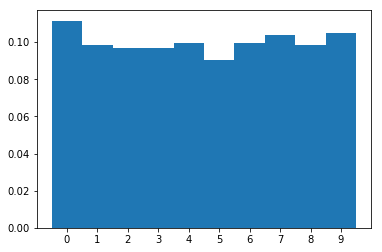

In [56]:
from collections import Counter
def show_prior_prob():
    labels, counts = zip(*Counter(label).items())
    total = sum(counts)
    pp = list(map(lambda x: x/float(total), counts))
    sorted_pp = [pp for _,pp in sorted(zip(labels,pp))]
    plt.bar(labels,sorted_pp,1)
    plt.xticks(arange(10),arange(10))
    plt.show()
show_prior_prob()


In [4]:
def mostNearestNeighbor(inX, dataMat, labelMat):
    dataSetSize = dataMat.shape[0]
    diffMat = tile(inX,(dataSetSize,1)) - dataMat
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = list(sqDistances**0.5)
    targetIndex = distances.index(min(distances))
    return min(distances),targetIndex, label[targetIndex]

def findUniqDigitsIndex():
    res = []
    for i in range(10):
        res.append(label.index(i))
    return res

def findNearestNeighborQuestion():
    for i in findUniqDigitsIndex():
        dataRemain = np.delete(array(data),(i), axis=0)
        labelRemain = np.delete(array(label),(i), axis=0)
        minDistance, predictedIndex, predictedValue = mostNearestNeighbor(data.iloc[i],dataRemain,labelRemain)
        print("Predicted Value :" + str(predictedValue) + " Actual value :" + str(label[i]))
        if str(predictedValue)!=str(label[i]):
            print("*")
findNearestNeighborQuestion()

Predicted Value :1 Actual value :0
*
Predicted Value :7 Actual value :1
*
Predicted Value :9 Actual value :2
*
Predicted Value :4 Actual value :3
*
Predicted Value :8 Actual value :4
*
Predicted Value :3 Actual value :5
*
Predicted Value :0 Actual value :6
*
Predicted Value :3 Actual value :7
*
Predicted Value :0 Actual value :8
*
Predicted Value :9 Actual value :9


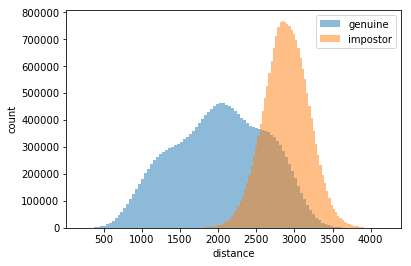

In [5]:
genuine,impostor =[],[]
def plotHistogram():
    dataMatBinary,labelMatBinary = [],[]
    for i in range(len(label)):
        if label[i]==0 or label[i]==1:
            dataMatBinary.append(data.iloc[i])
            labelMatBinary.append(label[i])
    dists = sklearn.metrics.pairwise.euclidean_distances(dataMatBinary)
    for (i_index,i),(j_index,j) in itertools.combinations(enumerate(labelMatBinary), 2):
        genuine.append(dists[i_index][j_index]) if i==j else impostor.append(dists[i_index][j_index])
    bins = 100
    labels = plt.subplot()
    labels.set_xlabel("distance")
    labels.set_ylabel("count")
    plt.hist(genuine, bins, alpha=0.5, label='genuine')
    plt.hist(impostor, bins, alpha=0.5, label='impostor')
    plt.legend(loc='upper right')
    plt.show()
    return dists
    
dists = plotHistogram()

In [1]:
def plotROC(genuine,impostor):
    tprarray,fprarray = [],[]
    genuine = np.array(genuine)
    impostor = np.array(impostor)
    for distance in range(int(amin(dists)),int(amax(dists)),50):
        tp = len(impostor[impostor>= distance])
        fp = len(genuine[genuine>= distance])
        fn = len(impostor) - tp
        tn = len(genuine) - fp
        tpr = tp / len(impostor)
        fpr = fp / len(genuine)
        tprarray.append( tpr )
        fprarray.append( fpr )
        if abs(fpr-1+tpr) < 0.03:
            eer = (fp+fn)/(tp+tn+fn+fp)
            print("equal error rate: ",eer)
    print("guess rate: ",len(impostor)/(len(impostor)+len(genuine)))
    
    plt.plot(fprarray,tprarray)
    plt.plot([0,1],[0,1],color='navy',linestyle='--')#roc when choose randomly
    plt.plot([0,1],[1,0],color='gray',linestyle='--',linewidth=0.5)#to get equal error rate
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
plotROC(genuine,impostor)

NameError: name 'genuine' is not defined

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from scipy.spatial.distance import cdist
from multiprocessing import Pool

# def nearestNeighborK(inX, dataMat, labelMat, k):
#     dataSetSize = dataMat.shape[0]
#     diffMat = tile(inX,(dataSetSize,1)) - dataMat
#     sqDiffMat = diffMat**2
#     sqDistances = sqDiffMat.sum(axis=1)
#     distances = sqDistances**0.5
#     sortedDistIndicies = distances.argsort()
#     classCount={}
#     for i in range(1,k+1):
#         voteIlabel = labelMat[sortedDistIndicies[i]]
#         classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
#     return max(classCount, key=classCount.get)

# def nearestNeighborKPairwise(inX, dataMat, labelMat, k):    
#     dists = sklearn.metrics.pairwise.euclidean_distances(inX,dataMat)
#     smallestKIndicies = np.argpartition(dists,k)[0][:k]
#     classCount={}
#     for i in range(0,k):
#         voteIlabel = labelMat[smallestKIndicies[i]]
#         classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
#     return max(classCount, key=classCount.get)

def reducedIndicies(testData, trainData, k, offset=0):
    dists = scipy.spatial.distance.cdist(testData,trainData, 'euclidean')
    sortedIndicies = np.argpartition(dists,k)
    result=[]
    for i, row in enumerate(sortedIndicies):
        r=[]
        for x in row[:k]:
            r.append((dists[i][x], x+offset))
        result.append(r)
    return result

## if testLabel given, it's a cross validation
def nearestNeighborKCdist(testData, trainData, trainLabel, k, testLabel=None):
    p = Pool(4)
    testOffset = len(testData)//2
    trainOffset = len(trainData)//2
    temp = p.starmap(reducedIndicies, [(testData[:testOffset], trainData[:trainOffset], k),
                            (testData[:testOffset], trainData[trainOffset:], k, trainOffset),
                            (testData[testOffset:], trainData[:trainOffset], k),
                            (testData[testOffset:], trainData[trainOffset:], k, trainOffset)])
    indicies = list(map(lambda x: x[0]+x[1],zip(temp[0], temp[1])))+list(map(lambda x: x[0]+x[1],zip(temp[2], temp[3])))                                                   
    sortedIndicies = [sorted(row) for row in indicies]
                                                            
    pred = []
    success = 0
    for ind, x in enumerate(sortedIndicies):
        classCount={}
        for i in range(0,k):
            voteIlabel = trainLabel[x[i][1]]
            classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
        if testLabel is not None: success += (max(classCount, key=classCount.get)==testLabel[ind])
        pred.append(max(classCount, key=classCount.get))
    successRate = success/len(testData)
    return successRate, pred

def generateConfusionMatrix(*fold):
    train_indices, test_indices, k = fold
    X_train = np.array(data)[train_indices]
    Y_train = np.array(label)[train_indices]
    X_test = np.array(data)[test_indices]
    Y_test = np.array(label)[test_indices]

    successRate, pred = nearestNeighborKCdist(X_test, X_train, Y_train, k, Y_test)
    print(confusion_matrix(array(pred), Y_test))
    return successRate

def performCrossValidation(sampleSize, k=3):
    if sampleSize is None: sampleSize = len(data)
    successRate = 0
    print("K is :", k)
    for train, test in (cross_validation.KFold(sampleSize, n_folds=3)):
        success = generateConfusionMatrix(train,test,k)
        successRate+=success
        print('success rate: ', success,'\n')
    print('\naverage success rate: ', successRate/3)

performCrossValidation(sampleSize = 5000)

K is : 3
[[161   0   0   1   0   1   2   0   1   2]
 [  0 175  10   1   1   3   1   2   5   3]
 [  0   1 181   2   0   0   0   0   0   1]
 [  0   0   3 128   0   5   0   0   8   1]
 [  0   0   0   0 148   1   0   2   1   2]
 [  0   1   0   2   0 141   0   1   7   0]
 [  4   0   0   0   1   0 166   0   0   0]
 [  0   0   7   2   1   0   0 158   2   7]
 [  0   1   5   1   0   2   0   0 126   0]
 [  0   0   0   1  16   0   0   4   4 154]]
success rate:  0.922615476905 

[[173   0   1   0   0   0   2   0   2   2]
 [  0 193   4   2   3   0   0   4   4   1]
 [  0   0 144   1   0   0   0   1   1   0]
 [  0   0   0 155   0   2   0   0   5   1]
 [  0   0   1   0 141   1   0   0   0  10]
 [  0   0   0   3   0 155   1   0   5   2]
 [  1   1   1   2   1   2 163   0   2   0]
 [  1   0   3   0   1   0   0 159   0   6]
 [  0   0   1   1   0   2   0   0 136   0]
 [  1   0   2   2  11   4   0   5   7 132]]
success rate:  0.930413917217 

[[148   0   5   0   0   0   1   0   1   1]
 [  0 183   4   1   2 

1 and 9 areparticularly tricky to classify

In [7]:
testSet=pd.read_csv('test.csv', sep=',',header=0)
_, pred = nearestNeighborKCdist(testSet, data,label,3)
with open('submission.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['ImageId','Label'])
    for i,r in enumerate(pred):
        spamwriter.writerow([i+1,r])